#### Preparations

* Checkout code with `git clone -b extreme_anomaly_package ssh://git@github.com/ankit-jha/addCustomIotFn`
* cd into the directory, adapt setup.py: turn all `==` operators into `>=` to avoid accidentially uninstalling stuff
* Run `pip install .`

In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, GBMRegressor)
from extremeanomaly.extremeanomalygenerator import ExtremeAnomalyGenerator

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1605: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    def str_norm(cols_str):
        '''norm for one string element (encodes an array of value)
           in one column of a data point'''
        return linalg.norm(np.fromstring(cols_str.replace('[',' ').replace(']','').replace('\"', ''), sep = ','))**2

    def column_norm(df, tcol, col1, col2=None, col3=None):
        '''norm of all columns specified in parameters for all datapoints'''
        df_temp = pd.DataFrame()
        df_temp['col1_np'] = df[col1].apply(str_norm)
        df_temp['col2_np'] = 0 
        df_temp['col3_np'] = 0
        if col2 is not None:
            df_temp['col2_np'] = df[col2].apply(str_norm)
        if col3 is not None:
            df_temp['col3_np'] = df[col3].apply(str_norm)

        return (df_temp['col1_np'] + df_temp['col2_np'] + df_temp['col3_np'])**(1/2)
    
    df[tcol] = column_norm(df, tcol, col1, col2, col3)


def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [3]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,2.170460,2208.854495,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,0.002922,589.925540,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,2.155864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,2.169444,2316.566425,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,2.170800,2318.802493,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,2.171949,2379.176328,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,2.184292,2672.101233,5.325799,5.293200,5.334001,5.278600,5.282000


#### Pandas Profiling

Try [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling) first, since srom's `DataQualityAdvisor` is currently not usable. 


In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_input, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_widgets()

#### DataQualityAdvisor

Import after pip-installing it from [IBM enterprise github](https://github.ibm.com/srom/DataQualityAdvisor/)



In [4]:
from dqlearn.ui.interactive.data_loader import data_loader_configuration_ui, data_loader_configuration, load_data
from dqlearn.ui.interactive.data_loader import load_data
from dqlearn.ui.interactive.display_data import display_data_ui
from dqlearn.ui.interactive.metadata_gen import column_metadata_dict, user_metadata_input_ui
from dqlearn.ui.interactive.data_insight import valid_list_ui
from dqlearn.dask.base_functions import value_properness_checks
from dqlearn.dask.base_functions import duplicate_value_checks
from dqlearn.dask.base_functions import uniqueness_checks
from dqlearn.tabular.transactional import check_low_variance_variables
from dqlearn.dask.base_functions import distribution_analyzer
from dqlearn.ai.ensemble_anomaly import anomaly_detection_isolation_forest
from dqlearn.ui.interactive.data_insight import valid_output_and_plot_ui
from dqlearn.ai.modelling_fit import check_data_modelling_fit
from dqlearn.ui.interactive.data_insight import valid_output_only_ui
from dqlearn.tabular.correlation import correlation_information
# from autodive.autoimpute import check_data_imputation

In [5]:
display_data_ui(df_input)

Output(layout=Layout(border='solid', height='350px', overflow_x='scroll', overflow_y='scroll', width='auto'))

In [6]:
user_metadata_input_ui(df_input)
column_metadata_dict


In [7]:
for i in column_metadata_dict:
    i = ['float64', 'data', 'numeric']
column_metadata_dict

{'vibrations': ['float64'],
 'rms': ['float64'],
 'accel_speed': ['float64'],
 'accel_power_0': ['float64'],
 'accel_power_1': ['float64'],
 'accel_power_2': ['float64'],
 'accel_power_3': ['float64'],
 'accel_power_4': ['float64']}

**Unfortunately the package is currently not in a usable state**

Last slack exchange:
```
@markus_mueller due to some changes in Ipywidgets and plotly version, this issue comes up. I'm looking into it and will let you know```

<br>

In [8]:
value_properness_analysis_result = value_properness_checks(df_input, column_metadata_dict)
valid_list_ui(value_properness_analysis_result)

In [9]:
validation_check_low_variance_variables = check_low_variance_variables(df_input)
valid_output_and_plot_ui(validation_check_low_variance_variables)[0]


In [10]:
distribution_result = distribution_analyzer(df_input, column_metadata_dict)
valid_list_ui(distribution_result)

In [11]:
valid_correlation = correlation_information(df_input, column_metadata_dict)
valid_output_and_plot_ui(valid_correlation)[0]

In [9]:
distribution_result = distribution_analyzer(df_input, column_metadata_dict)
valid_list_ui(distribution_result)

### Ankit's anomaly generator

Instantiating - but it won't work without credentials for database and cloud object store

<br>
<br>

In [27]:
# now run anomaly 
EngineLogging.configure_console_logging(logging.DEBUG)

extanomii = ExtremeAnomalyGenerator(input_item='vibrations',  output_item='vibrations_anom', factor=3, size=8)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = extanomii._build_entity_type(columns = [Column('vibrations_anom',Float())], **jobsettings)
extanomii._entity_type = et

df_input = extanomii.execute(df=df_input)

2020-02-26T10:20:29.276 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-02-26T10:20:29.277 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-02-26T10:20:29.279 DEBUG iotfunctions.util.__init__ Starting trace
2020-02-26T10:20:29.280 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_ExtremeAnomalyGenerator_20200226092029
2020-02-26T10:20:29.280 DEBUG iotfunctions.util.__init__ auto_save None
2020-02-26T10:20:29.281 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-02-26T10:20:29.281 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-02-26T10:20:29.281 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_EXTREMEANOMALYGENERATOR
Functions:
Granularities:
No schedules metadata
2020-02-26T10:20

2020-02-26T10:20:34.280 DEBUG extremeanomaly.extremeanomalygenerator.execute Time stamp indexes [2524, 3824, 7727]
2020-02-26T10:20:34.286 DEBUG extremeanomaly.extremeanomalygenerator.execute End function execution 2020-02-26 09:20:29.282657+00:00


In [28]:
df_input2 = df_input.loc[['04714B6046D5']]
df_input2.reset_index(level=[0], inplace=True)
Temperature='vibrations'
TempAnom='vibrations_anom'

Text(0, 0.5, 'Input data - next 2 hours')

2020-02-26T10:20:44.387 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
2020-02-26T10:20:44.387 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.388 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2020-02-26T10:20:44.388 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2020-02-26T10:20:44.388 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2020-02-26T10:20:44.389 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal

2020-02-26T10:20:44.415 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.416 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.416 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Regular.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.417 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal bold normal>) = 5.335
2020-02-26T10:20:44.417 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pagul' (Pagul.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.417 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-02-26T10:20:44.418

2020-02-26T10:20:44.437 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-02-26T10:20:44.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-02-26T10:20:44.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Meera' (Meera-Regular.ttf) normal normal regular normal>) = 10.05
2020-02-26T10:20:44.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-02-26T10:20:44.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_WinIE6' (MathJax_WinIE6-Regular.otf) normal normal regular normal>) = 10.05
2020-02-26

2020-02-26T10:20:44.462 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Medium.ttf) normal normal medium normal>) = 10.145
2020-02-26T10:20:44.463 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-02-26T10:20:44.463 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FontAwesome' (FontAwesome.otf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.463 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Italic.otf) italic normal 400 normal>) = 11.05
2020-02-26T10:20:44.464 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
2020-02-26T10:20:44.464 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Typewriter' (MathJax_Typewriter-Regular.otf) normal normal regular norma

2020-02-26T10:20:44.480 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-02-26T10:20:44.483 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Bold.otf) normal normal bold normal>) = 10.335
2020-02-26T10:20:44.484 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDigital' (KacstDigital.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.484 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
2020-02-26T10:20:44.484 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.485 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Math' (MathJax_Math-Regular.ot

2020-02-26T10:20:44.513 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-02-26T10:20:44.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal bold normal>) = 10.335
2020-02-26T10:20:44.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
2020-02-26T10:20:44.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal bold normal>) = 10.335
2020-02-26T10:20:44.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Bold.ttf) normal normal bold normal>) = 10.335
2020-02-26T10:20:44.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typist' (TlwgTypist.ttf) normal normal 400 normal>) = 10.05
2020-02-26T10:20:44.515 DEBUG matplotlib.

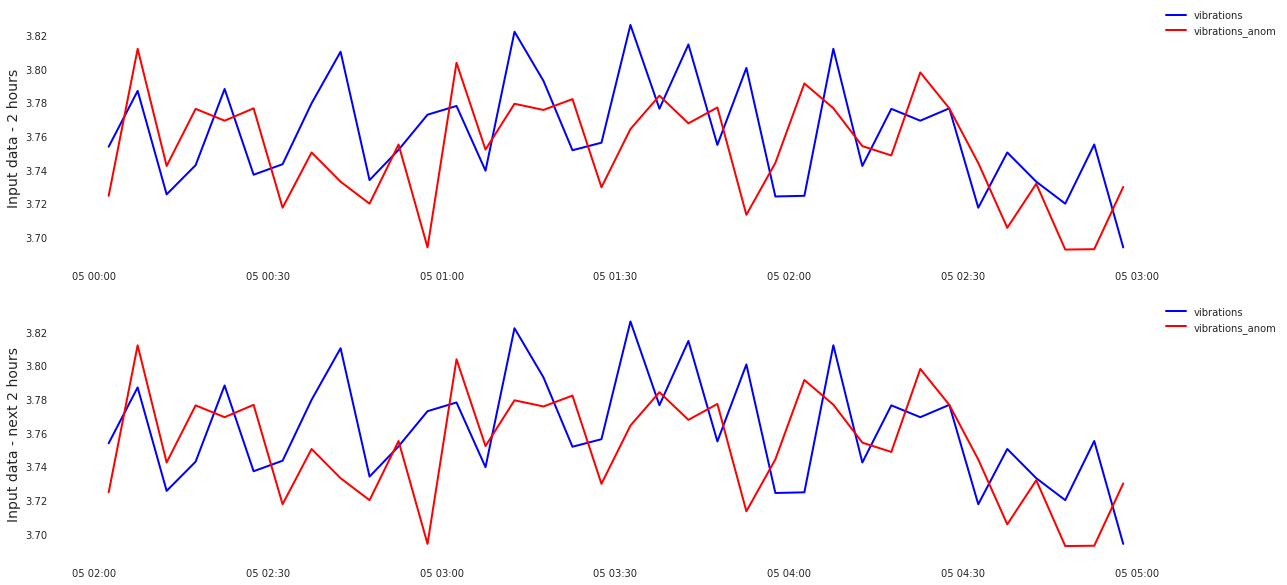

In [29]:
# Side plot - digging a bit deeper to look for seasonalities

plots = 2
df_sub1 = df_input2['2020-01-05 00':'2020-01-05 02']
df_sub2 = df_input2['2020-01-05 02':'2020-01-05 04']


fig, ax = plt.subplots(plots, 1, figsize=(20,10))
cnt = 0
ax[cnt].plot(df_sub1.index, df_sub1[Temperature],lw=2,color='blue',label=Temperature)
ax[cnt].plot(df_sub1.index, df_sub2[TempAnom],lw=2,color='red',label=TempAnom)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data - 2 hours', fontsize=14)
cnt = 1
ax[cnt].plot(df_sub2.index, df_sub1[Temperature],lw=2,color='blue',label=Temperature)
ax[cnt].plot(df_sub2.index, df_sub2[TempAnom],lw=2,color='red',label=TempAnom)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data - next 2 hours', fontsize=14)